In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import cv2
import csv

In [34]:
tf.keras.backend.set_image_data_format('channels_last')

In [35]:
train_path = './data/train/'
valid_path = './data/valid'
test_path = './data/test'

In [36]:
train_csv = './data/train.csv'
valid_csv = './data/valid.csv'
test_csv = './data/test.csv'

In [37]:
def append_ext(fn):    # Helper function to append extention name for image id
    return fn + ".jpg"

## Data Preprocess

In [38]:
# Data frames for image names and labels
train_df = pd.read_csv(train_csv)
valid_df = pd.read_csv(valid_csv)
test_df = pd.read_csv(test_csv)

In [39]:
train_df["image_id"] = train_df["image_id"].apply(append_ext)

In [40]:
valid_df["image_id"] = valid_df["image_id"].apply(append_ext)

In [41]:
test_df["image_id"] = test_df["image_id"].apply(append_ext)

In [42]:
train_df[:3]

,image_id,breed
0,597e09c5d0.jpg,agkistrodon-contortrix
1,a14a5ace05.jpg,pituophis-catenifer
2,5a35436f64.jpg,thamnophis-proximus


In [43]:
IMG_DIM=100
bs = 64

In [44]:
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.5, 1.0],
    brightness_range=[0.2, 1.0],
    horizontal_flip=True,
)

In [45]:
train_batches = datagen.flow_from_dataframe(
    train_df,
    directory=train_path,
    target_size=(IMG_DIM,IMG_DIM),
    x_col="image_id",
    y_col="breed",
    batch_size=bs
)

Found 4958 validated image filenames belonging to 35 classes.


In [ ]:
a = np.array(train_batches)

In [20]:
valid_batches = datagen.flow_from_dataframe(
    valid_df,
    directory=valid_path,
    target_size=(IMG_DIM, IMG_DIM),
    x_col="image_id",
    y_col="breed",
    batch_size=bs
)

Found 550 validated image filenames belonging to 35 classes.


## Sample Image Preview

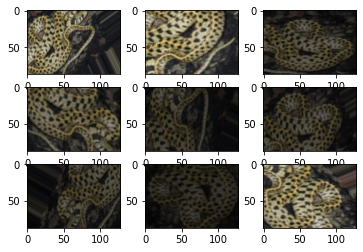

In [21]:
img = load_img("./data/train/0002023e6f.jpg")     # Sample Image
data = img_to_array(img)

samples = np.expand_dims(data, 0)

it = datagen.flow(samples, batch_size=1)
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

plt.show()

## Resnet models

In [24]:
ep = 20


In [26]:
resnet = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", classes=35,input_shape=(IMG_DIM, IMG_DIM, 3))

94773248/94765736 [==============================] - 10s 0us/step


In [30]:
model = Sequential()

In [32]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

conv5_block3_out (Activation)   (None, 4, 4, 2048)   0           conv5_block3_add[0][0]           
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [31]:
for layer in resnet.layers[:-1]:
    model.add(layer)
for layer in model.layers[:-2]:
    layer.trainable = False

ValueError: Input 0 of layer conv2_block1_3_conv is incompatible with the layer: expected axis -1 of input shape to have value 64 but received input with shape [None, 25, 25, 256]